In [1]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
# function to add salt and pepper noise
def add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = np.copy(image)
    
    # white noise
    num_salt = np.ceil(salt_prob * image.size)
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # black noise
    num_pepper = np.ceil(pepper_prob * image.size)
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image


In [3]:
# now using torchvision.transforms for a transformation pipeline
transform = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), 
    transforms.Lambda(lambda img: add_salt_pepper_noise(np.array(img), salt_prob=0.005, pepper_prob=0.005)), 
])

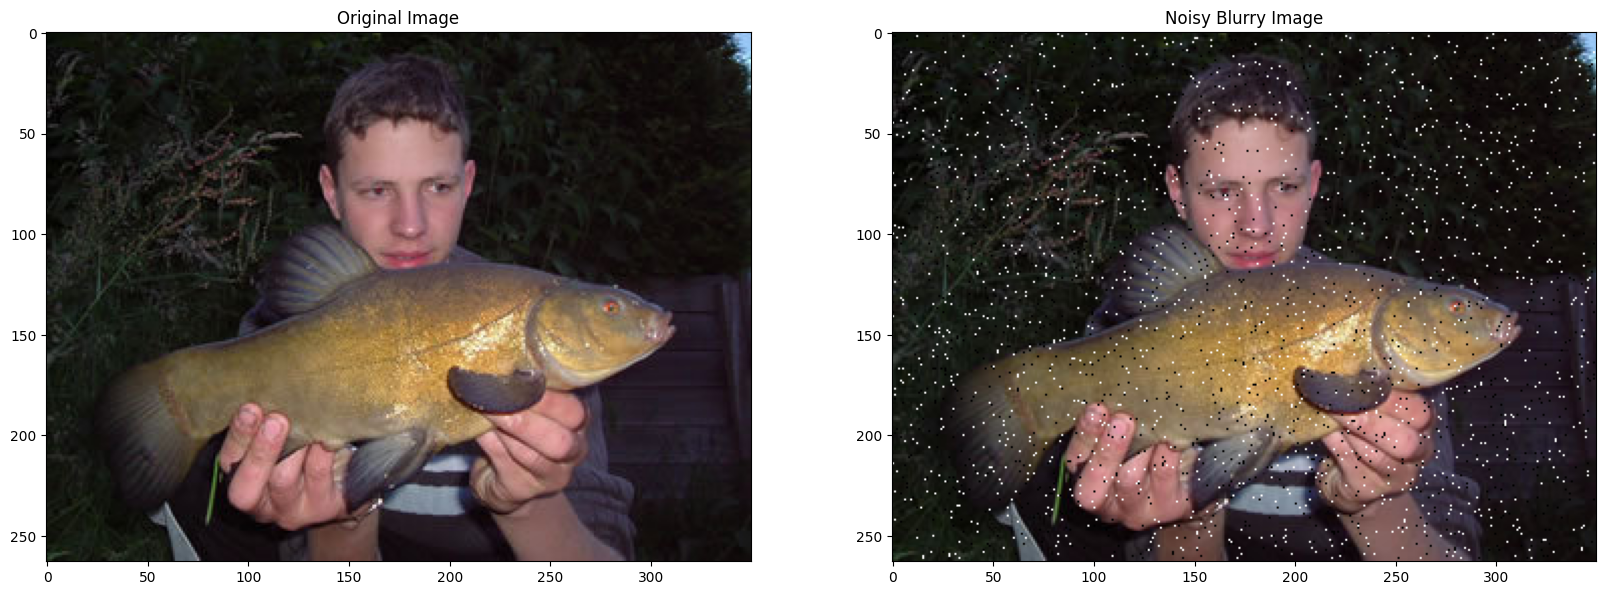

In [4]:
image = Image.open("/media/ori_quadro/newhd2/shubham_maindola/projects/autoencoder/data/datasets/tusonggao/imagenet-train-subset-100k/versions/1/imagenet_subtrain/n01440764/n01440764_457.JPEG").convert("RGB")
noisy_blurry_image = transform(image)

fig, ax = plt.subplots(1, 2, figsize=(20,8))

ax[0].imshow(image)
ax[1].imshow(noisy_blurry_image)

ax[0].set_title("Original Image")
ax[1].set_title("Noisy Blurry Image")

plt.show()

In [5]:
class NoisyBlurryDataset(Dataset):
    def __init__(self, image_paths, input_transform, label_transform):
        self.image_paths = image_paths
        self.input_transform = input_transform
        self.label_transform = label_transform

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        input_image = torch.from_numpy(self.input_transform(image)).permute(2, 0, 1).float() / 255.0
        label_image = self.label_transform(image)
        return input_image, label_image

    def __len__(self):
        return len(self.image_paths)

input_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), 
    transforms.Lambda(lambda img: add_salt_pepper_noise(np.array(img), salt_prob=0.005, pepper_prob=0.005)), 
])

label_transform = transforms.Compose([
    transforms.Resize((256,256)), 
    transforms.ToTensor()
])


In [6]:
image_paths = []

data_path = "/media/ori_quadro/newhd2/shubham_maindola/projects/autoencoder/data/datasets/tusonggao/imagenet-train-subset-100k/versions/1/imagenet_subtrain"
for directory in os.listdir(data_path): 
    for file in os.listdir(os.path.join(data_path, directory)): 
        image_paths.append(os.path.join(data_path, directory, file))
        
len(image_paths)


100000

In [7]:
# Load dataset
dataset = NoisyBlurryDataset(image_paths, input_transform=input_transform, label_transform=label_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [8]:
dataset[0]


(tensor([[[0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          [0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          [0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          ...,
          [0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          [0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          [0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          ...,
          [0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          [0.0353, 0.0353, 0.0353,  ..., 0.0078, 0.0078, 0.0078],
          [0.0353, 0.0353, 0.0353,  ...,

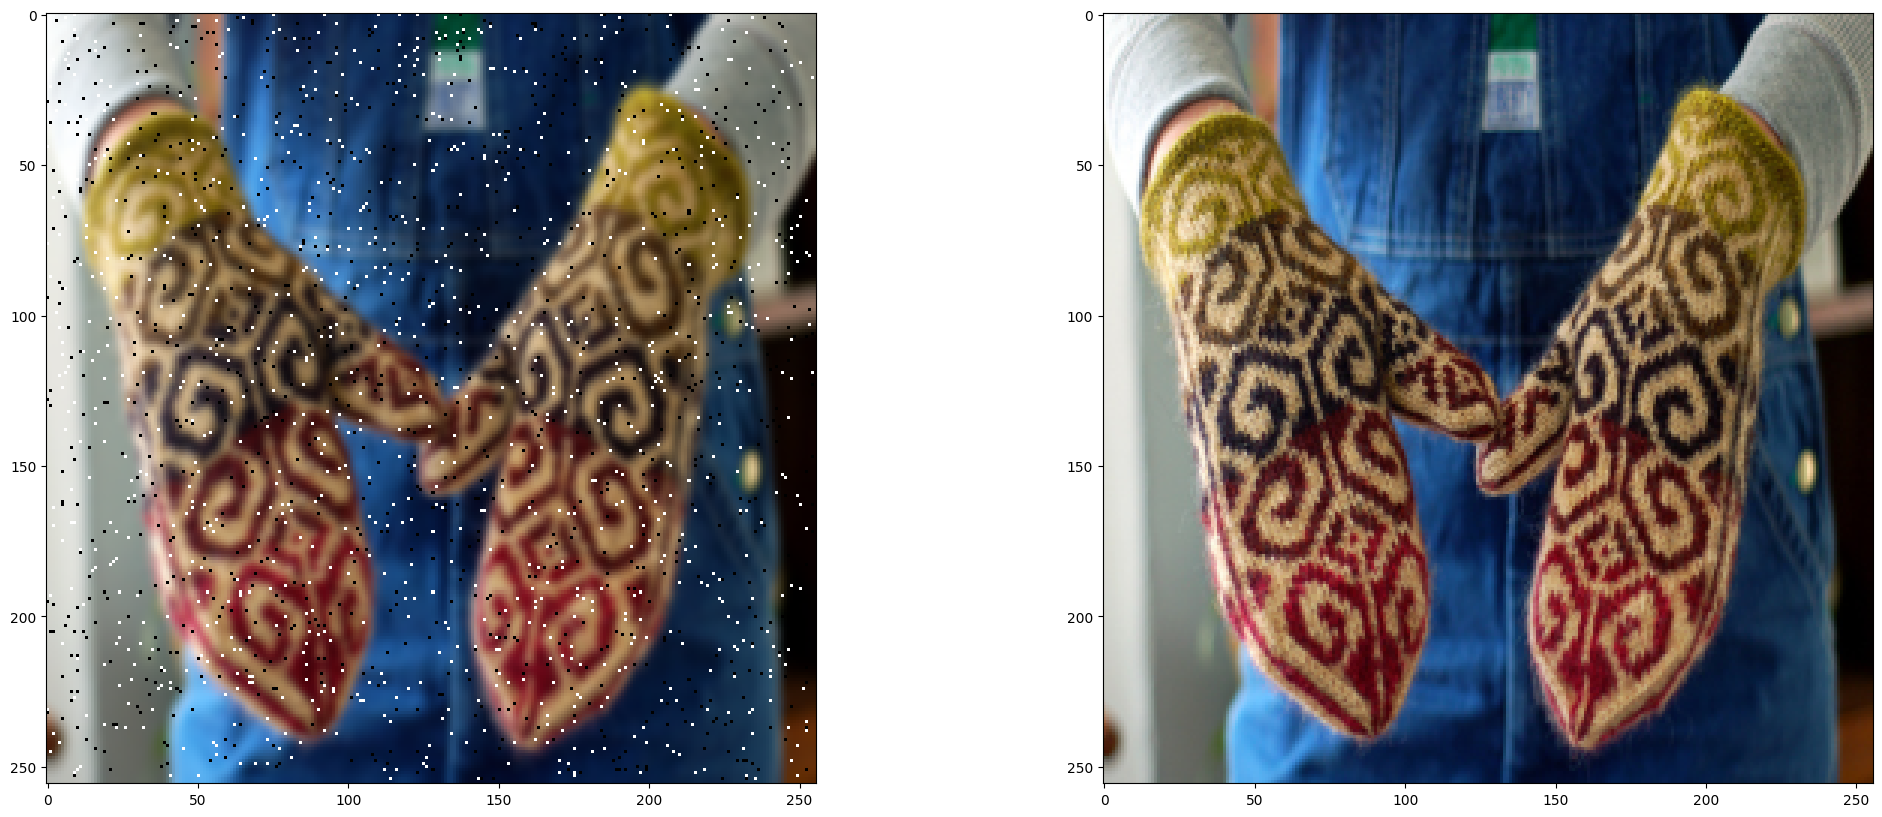

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))

ax[0].imshow(dataset[3000][0].permute(1,2,0))
ax[1].imshow(dataset[3000][1].permute(1,2,0))

plt.show()

In [10]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder()

In [11]:
import torchvision.models as models

# L1 Loss
l1_loss = nn.L1Loss()

# Load VGG16 for perceptual loss (feature similarity)
vgg = models.vgg16(pretrained=True).features[:16].eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

# Function for Perceptual Loss
def perceptual_loss(fake, real):
    fake_features = vgg(fake)
    real_features = vgg(real)
    return l1_loss(fake_features, real_features)

# Compute SSIM Loss
def ssim_loss(img1, img2):
    from pytorch_msssim import ssim
    return 1 - ssim(img1, img2, data_range=1.0, size_average=True)

# Final Loss Function
def total_loss(fake, real):
    return l1_loss(fake, real) + 0.1 * perceptual_loss(fake, real) + 0.5 * ssim_loss(fake, real)


/home/ori_quadro/miniconda3/envs/maindola_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ori_quadro/miniconda3/envs/maindola_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import torch.optim as optim

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for noisy_imgs, clean_imgs in dataloader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = total_loss(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")


Epoch [1/60], Loss: 0.1810
Epoch [2/60], Loss: 0.1295
Epoch [3/60], Loss: 0.1190
Epoch [4/60], Loss: 0.1165
Epoch [5/60], Loss: 0.1147
Epoch [6/60], Loss: 0.1136
Epoch [7/60], Loss: 0.1127
Epoch [8/60], Loss: 0.1120
Epoch [9/60], Loss: 0.1115
Epoch [10/60], Loss: 0.1111
Epoch [11/60], Loss: 0.1105
Epoch [12/60], Loss: 0.1103
Epoch [13/60], Loss: 0.1099
Epoch [14/60], Loss: 0.1097
Epoch [15/60], Loss: 0.1093
Epoch [16/60], Loss: 0.1091
Epoch [17/60], Loss: 0.1090
Epoch [18/60], Loss: 0.1087
Epoch [19/60], Loss: 0.1086
Epoch [20/60], Loss: 0.1084
Epoch [21/60], Loss: 0.1083
Epoch [22/60], Loss: 0.1080
Epoch [23/60], Loss: 0.1080
Epoch [24/60], Loss: 0.1079
Epoch [25/60], Loss: 0.1068
Epoch [26/60], Loss: 0.1063
Epoch [27/60], Loss: 0.1061
Epoch [28/60], Loss: 0.1061
Epoch [29/60], Loss: 0.1058
Epoch [30/60], Loss: 0.1059
Epoch [31/60], Loss: 0.1057
Epoch [32/60], Loss: 0.1056
Epoch [33/60], Loss: 0.1056
Epoch [34/60], Loss: 0.1054
Epoch [35/60], Loss: 0.1053
Epoch [36/60], Loss: 0.1052
E

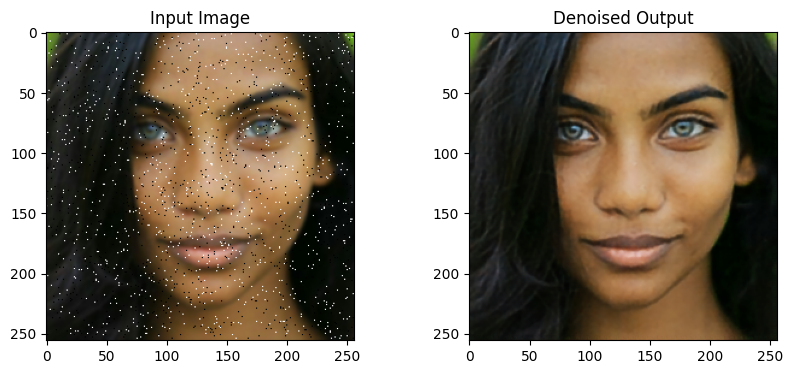

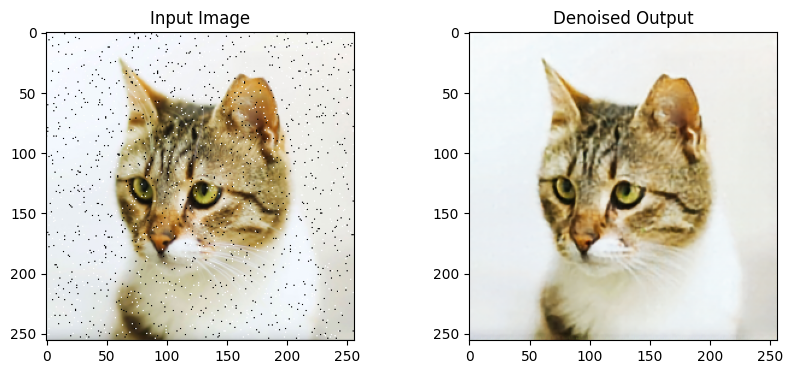

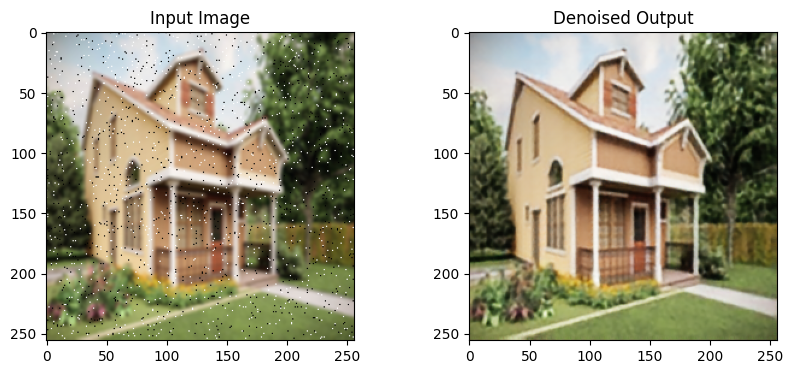

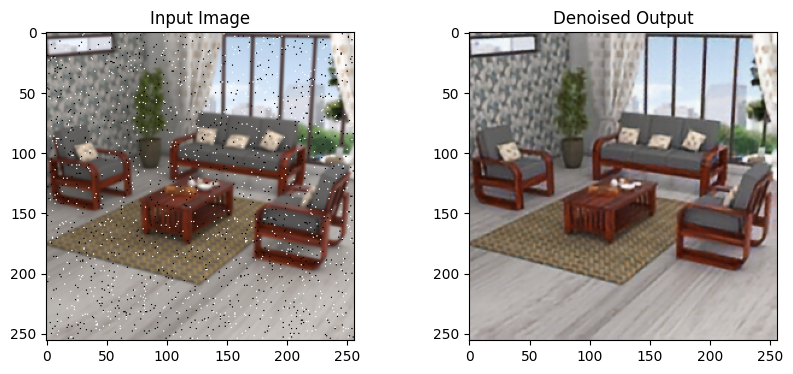

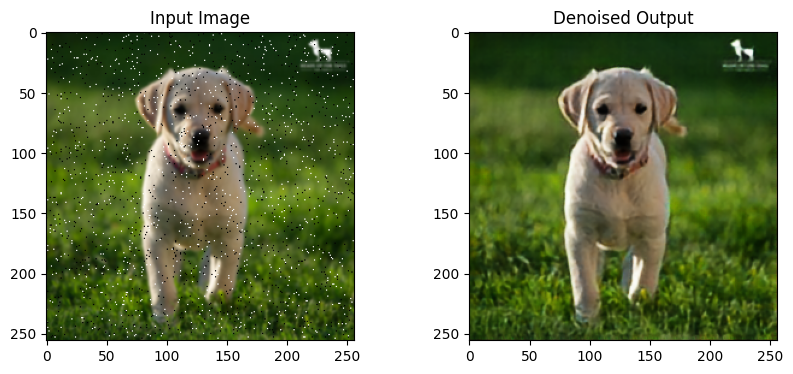

In [15]:
# testing on real images
test_data_path = "/media/ori_quadro/newhd2/shubham_maindola/projects/autoencoder/data/test_data"
for file in os.listdir(test_data_path): 
    file_path = os.path.join(test_data_path, file)
    with torch.no_grad():
        clean_image = Image.open(file_path).convert("RGB")
        input_image = (torch.from_numpy(input_transform(clean_image)).permute(2, 0, 1).float() / 255.0).to(device)
        output = model(input_image)
        
    denoised_image = output.squeeze(0).cpu().detach() 
    denoised_image = transforms.ToPILImage()(denoised_image)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(input_image.cpu().permute(1,2,0))
    ax[0].set_title("Input Image")
    ax[1].imshow(denoised_image)
    ax[1].set_title("Denoised Output")
    plt.show()

In [16]:
torch.save(model, "denoising_autoencoder_model.pth")
